In [2]:
import re # expressoes regulares
import time
import sqlite3
import pycountry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # datavis
from matplotlib import cm # datavis
from sklearn.feature_extraction.text import CountVectorizer
import warnings

warnings.filterwarnings('ignore')
sns.set_theme(style = 'whitegrid')

In [3]:
conn = sqlite3.connect('imdb.db')

In [12]:
tabelas = pd.read_sql_query("SELECT name AS 'table_name' FROM sqlite_master WHERE type = 'table'",conn)

In [13]:
type(tabelas)

pandas.core.frame.DataFrame

In [15]:
tabelas.head()

,table_name
0,people
1,titles
2,akas
3,crew
4,episodes


In [16]:
tabelas = tabelas["table_name"].values.tolist()

In [18]:
for tabela in tabelas:
    consulta = "PRAGMA TABLE_INFO({})".format(tabela)
    resultado = pd.read_sql_query(consulta,conn)
    print('Esquema da tabela: ',tabela)
    display(resultado)
    print('-'*100 + '\n')

Esquema da tabela:  people


,cid,name,type,notnull,dflt_value,pk
0,0,person_id,VARCHAR,0,None,1
1,1,name,VARCHAR,0,None,0
2,2,born,INTEGER,0,None,0
3,3,died,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------

Esquema da tabela:  titles


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,type,VARCHAR,0,None,0
2,2,primary_title,VARCHAR,0,None,0
3,3,original_title,VARCHAR,0,None,0
4,4,is_adult,INTEGER,0,None,0
5,5,premiered,INTEGER,0,None,0
6,6,ended,INTEGER,0,None,0
7,7,runtime_minutes,INTEGER,0,None,0
8,8,genres,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------

Esquema da tabela:  akas


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,title,VARCHAR,0,None,0
2,2,region,VARCHAR,0,None,0
3,3,language,VARCHAR,0,None,0
4,4,types,VARCHAR,0,None,0
5,5,attributes,VARCHAR,0,None,0
6,6,is_original_title,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------

Esquema da tabela:  crew


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,person_id,VARCHAR,0,None,0
2,2,category,VARCHAR,0,None,0
3,3,job,VARCHAR,0,None,0
4,4,characters,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------

Esquema da tabela:  episodes


,cid,name,type,notnull,dflt_value,pk
0,0,episode_title_id,INTEGER,0,None,0
1,1,show_title_id,INTEGER,0,None,0
2,2,season_number,INTEGER,0,None,0
3,3,eposide_number,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------

Esquema da tabela:  ratings


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,rating,INTEGER,0,None,0
2,2,votes,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------



# 1 - Quais são as categorias de filmes mais comuns
## Quais são os principais tipos (categorias) dos títulos (filmes)?

In [25]:
consulta1 = '''SELECT type, count(*) as cont from titles group by type'''
resultado1 = pd.read_sql_query(consulta1,conn)
display(resultado1)

,type,cont
0,movie,584245
1,radioEpisode,1
2,radioSeries,1
3,short,824167
4,tvEpisode,5963818
5,tvMiniSeries,38662
6,tvMovie,132412
7,tvSeries,212057
8,tvShort,10163
9,tvSpecial,33584


In [26]:
resultado1['%'] = (resultado1['cont'] / resultado1['cont'].sum()) * 100
display(resultado1)

,type,cont,%
0,movie,584245,7.173581
1,radioEpisode,1,0.000012
2,radioSeries,1,0.000012
3,short,824167,10.119434
4,tvEpisode,5963818,73.226014
5,tvMiniSeries,38662,0.474707
6,tvMovie,132412,1.625805
7,tvSeries,212057,2.603716
8,tvShort,10163,0.124785
9,tvSpecial,33584,0.412357


In [27]:
outros = {}
outros['cont'] = resultado1[resultado1['%'] < 5]['cont'].sum()
outros['%'] = resultado1[resultado1['%'] < 5]['%'].sum()
outros['type'] = 'outros'
outros

{'cont': 772168, '%': 9.480970846464036, 'type': 'outros'}

In [28]:
resultado1 = resultado1[resultado1['%'] > 5]
resultado1 = resultado1.append(outros,ignore_index = True)
resultado1 = resultado1.sort_values(by = 'cont', ascending = False)
display(resultado1)

,type,cont,%
2,tvEpisode,5963818,73.226014
1,short,824167,10.119434
3,outros,772168,9.480971
0,movie,584245,7.173581


In [36]:
rotulos = [str(resultado1['type'][i]) +': '+ str(round(resultado1['%'][i],2)) + '%' for i in resultado1.index]

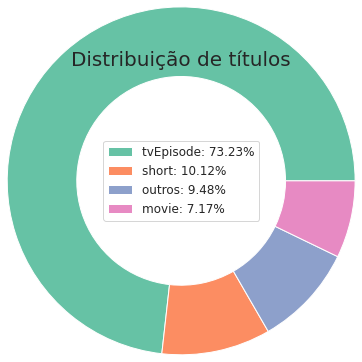

In [37]:
cs = cm.Set2(np.arange(100))
f = plt.figure()
plt.pie(resultado1['cont'],labeldistance = 1, radius = 2, colors = cs, wedgeprops = dict(width = 0.8))
plt.legend(labels = rotulos, loc = 'center', prop = {'size': 12})
plt.title('Distribuição de títulos', loc = 'center', fontdict = {'fontsize': 20, 'fontweight': 20})
plt.show()

# Qual o número de títulos por gênero?

In [38]:
consulta2 = '''SELECT genres, count(*) FROM titles WHERE type = 'movie' GROUP BY genres'''
resultado2 = pd.read_sql_query(consulta2,conn)
display(resultado2)

,genres,count(*)
0,Action,13304
1,"Action,Adult",11
2,"Action,Adult,Adventure",1
3,"Action,Adult,Comedy",5
4,"Action,Adult,Crime",10
...,...,...
1439,"Thriller,Western",39
1440,War,1248
1441,"War,Western",9
1442,Western,4024


In [39]:
resultado2['genres'] = resultado2['genres'].str.lower().values

In [40]:
temp = resultado2['genres'].dropna()

In [41]:
padrao = '(?u)\\b[\\w-]+\\b'
vetor = CountVectorizer(token_pattern = padrao, analyzer = 'word').fit(temp)
type(vetor)

sklearn.feature_extraction.text.CountVectorizer

In [42]:
generos = vetor.transform(temp)
type(generos)

In [43]:
generosUnicos = vetor.get_feature_names()
generos = pd.DataFrame(generos.todense(),columns = generosUnicos, index = temp.index)
generos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1444 entries, 0 to 1443
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   action       1444 non-null   int64
 1   adult        1444 non-null   int64
 2   adventure    1444 non-null   int64
 3   animation    1444 non-null   int64
 4   biography    1444 non-null   int64
 5   comedy       1444 non-null   int64
 6   crime        1444 non-null   int64
 7   documentary  1444 non-null   int64
 8   drama        1444 non-null   int64
 9   family       1444 non-null   int64
 10  fantasy      1444 non-null   int64
 11  film-noir    1444 non-null   int64
 12  game-show    1444 non-null   int64
 13  history      1444 non-null   int64
 14  horror       1444 non-null   int64
 15  music        1444 non-null   int64
 16  musical      1444 non-null   int64
 17  mystery      1444 non-null   int64
 18  n            1444 non-null   int64
 19  news         1444 non-null   int64
 20  reality-

In [44]:
generos = generos.drop(columns = 'n', axis = 0)

In [45]:
generosPercentual = 100 * pd.Series(generos.sum()).sort_values(ascending = False) / generos.shape[0]
generosPercentual.head(10)

drama          18.421053
comedy         16.828255
documentary    15.997230
adventure      14.889197
action         14.612188
romance        13.504155
crime          13.019391
mystery        12.603878
thriller       12.396122
fantasy        12.257618
dtype: float64

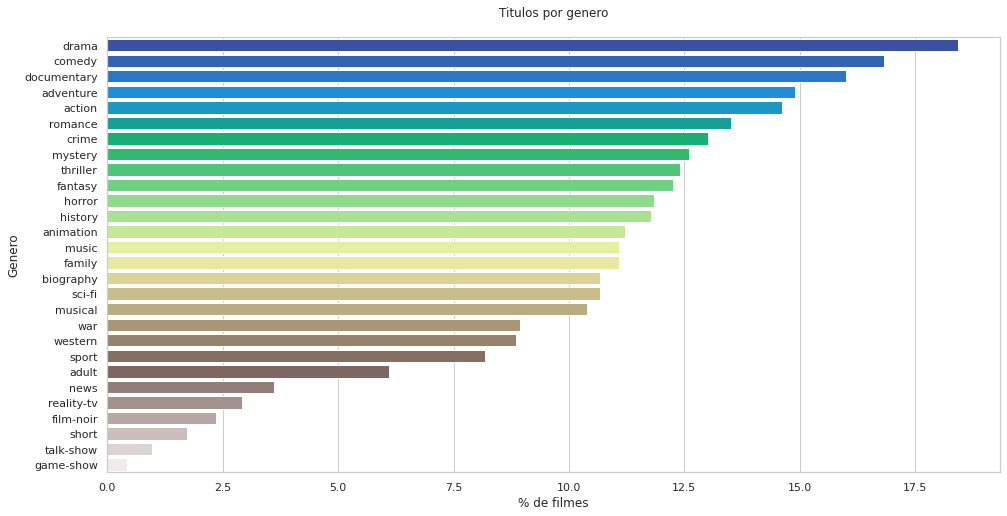

In [47]:
plt.figure(figsize = (16,8))
sns.barplot(x = generosPercentual.values, y = generosPercentual.index, orient = 'h', palette = 'terrain')
plt.ylabel('Genero')
plt.xlabel('% de filmes')
plt.title('Titulos por genero\n')
plt.show()